# STA365 Homework 6

## Q1: Let's start having some *real* fun...

We previously considered the normal-gamma specification 

$$\scriptsize
\begin{align*}
p(\theta,\tau|x) &\propto{} p(\theta,\tau,x) = p(x|\theta)p(\theta)p(\tau) \quad (\theta \perp\!\!\perp \tau) \leftarrow \text{independent priors} & p(\theta|x,\theta_0,\tau_0, \tau) &={} \text{N}\left(\frac{\left(\tau_0 \theta_0+\tau\sum_{i=1}^{n}x_{i}\right)}{(\tau_0+n\tau)}, \sigma^{-2}=\tau_0+n\tau \right)\\
&={}  \left[\prod_{i=1}^n\sqrt{\frac{\tau}{2\pi}} e^{-\frac{\tau\left(x_i-\theta\right)^2}{2}}\right] \sqrt{\frac{\tau_0}{2\pi}} e^{-\frac{\tau_0\left(\theta-\theta_0\right)^2}{2}} \frac{\beta ^{\alpha}}{\Gamma(\alpha)} \tau^{\alpha -1}e^{-\beta \tau} & p(\tau|x, \alpha, \beta, \theta) &={} \text{Gamma}\left(\frac{\alpha}{2}+\frac{n}{2}, \frac{\beta}{2}+\frac{1}{2}\sum_{i=1}^n\left(x_i-\theta\right)^2 \right)\\{}\\
\end{align*}$$

How about instead we consider a "[location-scale-t](https://en.wikipedia.org/wiki/Student%27s_t-distribution#Location-scale_t-distribution)-norm-halfnorm-discrete-uniform" specification?

$$\large
\overset{x_i\; \sim\; \text{location-scale-t}(\mu, \sigma^2, \nu)}{\quad\quad\quad p(x|\mu,\sigma^2, \nu)} = {\prod_{i=1}^n
\frac{\Gamma\left(\frac{\nu+1}{2}\right)}{\Gamma\left(\frac{\nu}{2}\right) \sqrt{\pi \nu \sigma^2}}\left(1+\frac{1}{\nu} \frac{(x_i-\mu)^2}{\sigma^2}\right)^{-(\nu+1) / 2}}$$

$$\scriptsize 
\begin{align}
p(\mu | \mu_0, \tau_0) &={} \sqrt{\frac{\tau_0}{2\pi}} e^{-\frac{\tau_0}{2}\left(\mu-\mu_0\right)^2} & p(\sigma^2 | \sigma_0^2) &={} \sqrt{\frac{2}{\pi\sigma_0^2}} \exp \left(-\frac{(\sigma^2)^2}{2 \sigma_0^2}\right) 1_{[0,\infty]}(\sigma^2) & p(\nu=i) &={} \Bigg\{ \begin{array}{cl} \frac{1}{100} & \text{for }i=1,\cdots,100\\ 0 & \text{otherwise} \end{array}\\
& \textrm{normal} && \textrm{half-normal} && \textrm{discrete uniform}
\end{align}
$$

Um yeah we're gonna need a Metroposlis cleanup on aisles one two and three  
(or a slice or adapative squeeze rejection sampling steps... in place of Metroposlis steps)

*Implement the a Metroposlis within Gibbs algorithm to smaple from the posterior of the above specification. Use a "smallish" sample size, say $n=100$ and implement your acceptance probability on a log-scale as described in [piazza post @65_f1](https://piazza.com/class/m5jvyco84083fm/post/65_f1)*

  0%|          | 0/4999 [00:00<?, ?it/s]

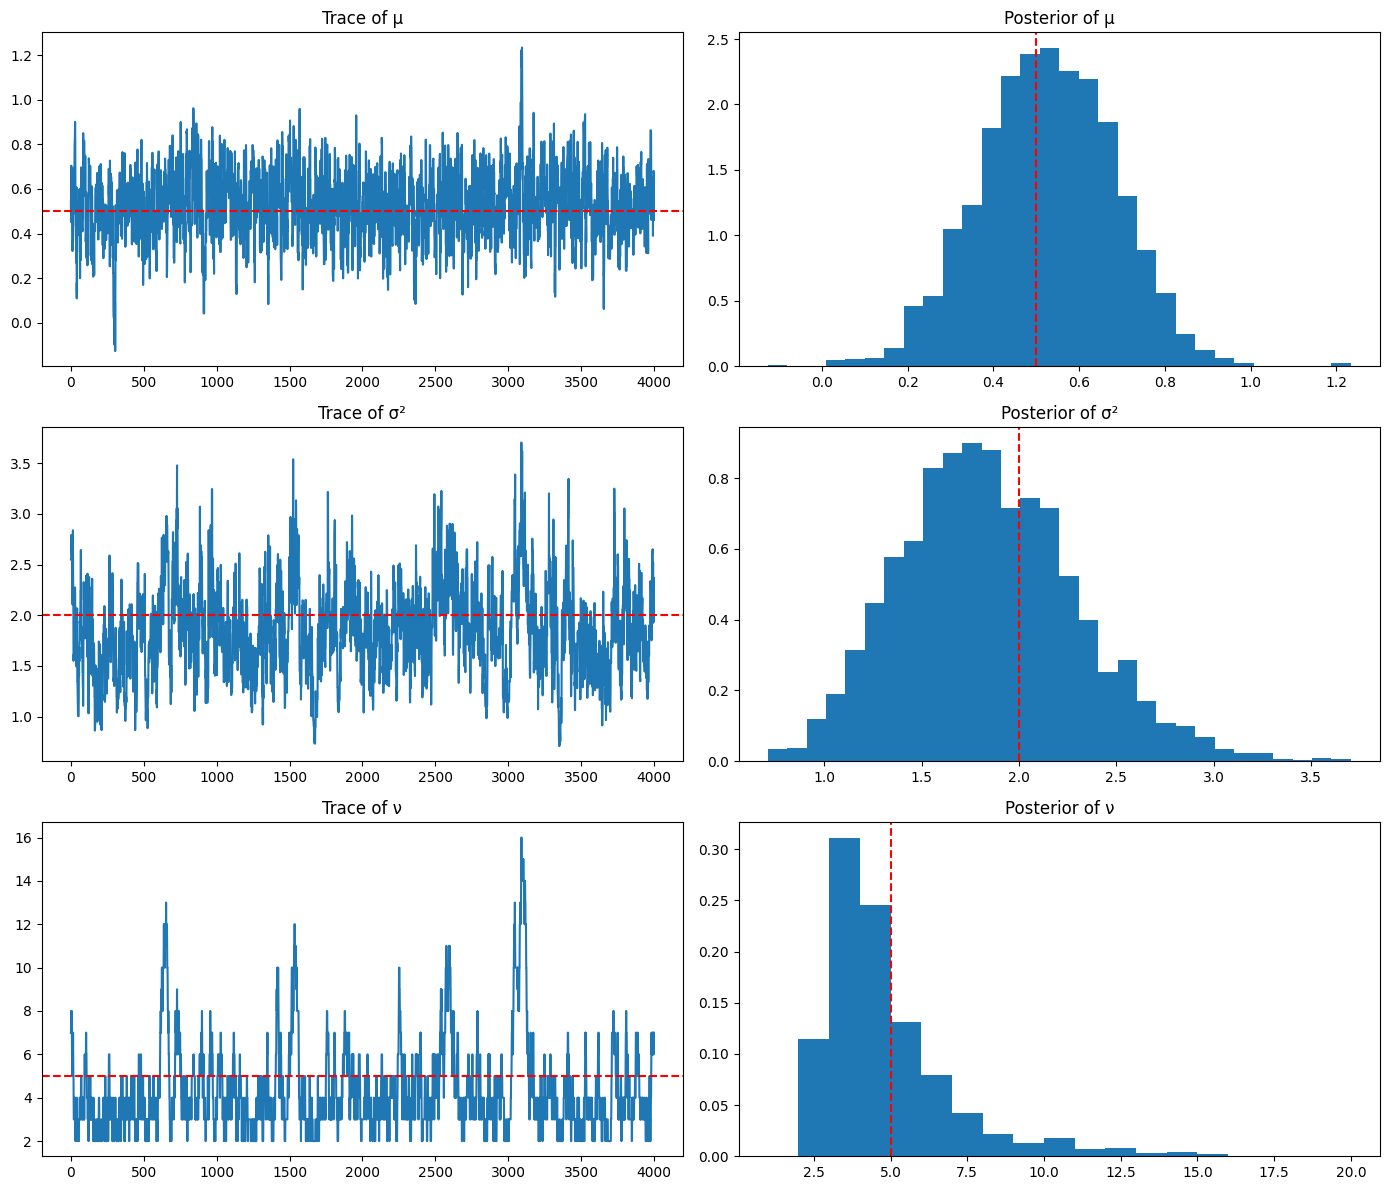

True μ: 0.5000, Posterior mean: 0.5259, 95% CI: [0.2181, 0.8203]
True σ²: 2.0000, Posterior mean: 1.8446, 95% CI: [1.0521, 2.8318]
True ν: 5, Posterior mode: 3, 95% CI: [2.0, 10.0]


In [4]:
import numpy as np
from scipy.special import gammaln
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from scipy import stats

# Generate synthetic data from a t-distribution
np.random.seed(365)
n = 100  # Sample size
true_mu = 0.5
true_sigma2 = 2.0
true_nu = 5

# Generate data from a t-distribution
x = stats.t(df=true_nu, loc=true_mu, scale=np.sqrt(true_sigma2)).rvs(n)

# Prior hyperparameters
mu0 = 0.0
tau0 = 1.0
sigma0_2 = 5.0

# Metropolis-within-Gibbs settings
n_iterations = 5000
burnin = 1000

# Initialize arrays to store samples
mu_samples = np.zeros(n_iterations)
sigma2_samples = np.zeros(n_iterations)
nu_samples = np.zeros(n_iterations, dtype=int)

# Initialize parameters
mu_samples[0] = 0.0
sigma2_samples[0] = 1.0
nu_samples[0] = 10

# Functions for log-posteriors
def log_likelihood(x, mu, sigma2, nu):
    """Log likelihood for t-distribution"""
    n = len(x)
    log_lik = (
        n * (
            gammaln((nu + 1) / 2) - 
            gammaln(nu / 2) -
            0.5 * np.log(np.pi * nu * sigma2)
        )
    )
    
    for i in range(n):
        log_lik -= ((nu + 1) / 2) * np.log(1 + (1 / nu) * ((x[i] - mu) ** 2) / sigma2)
    
    return log_lik

def log_prior_mu(mu, mu0, tau0):
    """Log prior for μ - Normal"""
    return stats.norm(mu0, 1 / np.sqrt(tau0)).logpdf(mu)

def log_prior_sigma2(sigma2, sigma0_2):
    """Log prior for σ² - Half-Normal"""
    if sigma2 <= 0:
        return -np.inf
    return np.log(np.sqrt(2 / (np.pi * sigma0_2))) - (sigma2 ** 2) / (2 * sigma0_2)

def log_prior_nu(nu):
    """Log prior for ν - Discrete Uniform"""
    if 1 <= nu <= 100:
        return np.log(1/100)
    return -np.inf

def log_posterior_mu(mu, sigma2, nu, x, mu0, tau0):
    """Log posterior for μ"""
    return log_likelihood(x, mu, sigma2, nu) + log_prior_mu(mu, mu0, tau0)

def log_posterior_sigma2(mu, sigma2, nu, x, sigma0_2):
    """Log posterior for σ²"""
    return log_likelihood(x, mu, sigma2, nu) + log_prior_sigma2(sigma2, sigma0_2)

def log_posterior_nu(mu, sigma2, nu, x):
    """Log posterior for ν"""
    return log_likelihood(x, mu, sigma2, nu) + log_prior_nu(nu)

# Metropolis-within-Gibbs algorithm
for t in tqdm(range(1, n_iterations)):
    # Current values
    mu_current = mu_samples[t-1]
    sigma2_current = sigma2_samples[t-1]
    nu_current = nu_samples[t-1]
    
    # Step 1: Update μ using Metropolis
    mu_proposal = stats.norm(mu_current, 0.2).rvs()
    log_accept_ratio = log_posterior_mu(mu_proposal, sigma2_current, nu_current, x, mu0, tau0) - \
                       log_posterior_mu(mu_current, sigma2_current, nu_current, x, mu0, tau0)
    
    if np.log(np.random.uniform()) < log_accept_ratio:
        mu_samples[t] = mu_proposal
    else:
        mu_samples[t] = mu_current
    
    # Step 2: Update σ² using Metropolis
    # Using log-normal proposal to ensure positivity
    sigma2_proposal = sigma2_current * np.exp(stats.norm(0, 0.2).rvs())
    log_accept_ratio = log_posterior_sigma2(mu_samples[t], sigma2_proposal, nu_current, x, sigma0_2) - \
                       log_posterior_sigma2(mu_samples[t], sigma2_current, nu_current, x, sigma0_2)
    
    # Adjustment for asymmetric proposal
    log_accept_ratio += np.log(sigma2_proposal) - np.log(sigma2_current)
    
    if np.log(np.random.uniform()) < log_accept_ratio:
        sigma2_samples[t] = sigma2_proposal
    else:
        sigma2_samples[t] = sigma2_current
    
    # Step 3: Update ν using Metropolis on integers
    # Propose a move in {-1, 0, 1} to maintain locality
    nu_step = np.random.choice([-1, 0, 1])
    nu_proposal = max(1, min(100, nu_current + nu_step))
    
    if nu_proposal != nu_current:
        log_accept_ratio = log_posterior_nu(mu_samples[t], sigma2_samples[t], nu_proposal, x) - \
                          log_posterior_nu(mu_samples[t], sigma2_samples[t], nu_current, x)
        
        if np.log(np.random.uniform()) < log_accept_ratio:
            nu_samples[t] = nu_proposal
        else:
            nu_samples[t] = nu_current
    else:
        nu_samples[t] = nu_current

# Discard burn-in
mu_samples = mu_samples[burnin:]
sigma2_samples = sigma2_samples[burnin:]
nu_samples = nu_samples[burnin:]

# Plot results
fig, axes = plt.subplots(3, 2, figsize=(14, 12))

# Trace plots
axes[0, 0].plot(mu_samples)
axes[0, 0].set_title('Trace of μ')
axes[0, 0].axhline(true_mu, color='r', linestyle='--')

axes[1, 0].plot(sigma2_samples)
axes[1, 0].set_title('Trace of σ²')
axes[1, 0].axhline(true_sigma2, color='r', linestyle='--')

axes[2, 0].plot(nu_samples)
axes[2, 0].set_title('Trace of ν')
axes[2, 0].axhline(true_nu, color='r', linestyle='--')

# Histograms
axes[0, 1].hist(mu_samples, bins=30, density=True)
axes[0, 1].set_title('Posterior of μ')
axes[0, 1].axvline(true_mu, color='r', linestyle='--')

axes[1, 1].hist(sigma2_samples, bins=30, density=True)
axes[1, 1].set_title('Posterior of σ²')
axes[1, 1].axvline(true_sigma2, color='r', linestyle='--')

axes[2, 1].hist(nu_samples, bins=np.arange(1, 21), density=True)
axes[2, 1].set_title('Posterior of ν')
axes[2, 1].axvline(true_nu, color='r', linestyle='--')

plt.tight_layout()
plt.show()

# Calculate posterior means and credible intervals
print(f"True μ: {true_mu:.4f}, Posterior mean: {np.mean(mu_samples):.4f}, 95% CI: [{np.percentile(mu_samples, 2.5):.4f}, {np.percentile(mu_samples, 97.5):.4f}]")
print(f"True σ²: {true_sigma2:.4f}, Posterior mean: {np.mean(sigma2_samples):.4f}, 95% CI: [{np.percentile(sigma2_samples, 2.5):.4f}, {np.percentile(sigma2_samples, 97.5):.4f}]")
print(f"True ν: {true_nu}, Posterior mode: {stats.mode(nu_samples).mode}, 95% CI: [{np.percentile(nu_samples, 2.5):.1f}, {np.percentile(nu_samples, 97.5):.1f}]")

### Q2: explore the role of sample size in providing inference for the degrees of freedom parameter $\nu$

*Implement the specification above using `PyMC` where you can explore inference on $\nu$ at different sample sizes. Provide a summarization and explanation of your findings.*

Running inference with sample size = 20


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [mu, sigma2]
>Metropolis: [nu]


Output()

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Running inference with sample size = 50


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [mu, sigma2]
>Metropolis: [nu]


Output()

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Running inference with sample size = 100


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [mu, sigma2]
>Metropolis: [nu]


Output()

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


Running inference with sample size = 200


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [mu, sigma2]
>Metropolis: [nu]


Output()

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Running inference with sample size = 500


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [mu, sigma2]
>Metropolis: [nu]


Output()

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Running inference with sample size = 1000


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [mu, sigma2]
>Metropolis: [nu]


Output()

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
/var/folders/0n/01wpsp7524jcr22yn6ykjtjr0000gn/T/ipykernel_53197/3831663408.py:124: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(box_data, labels=sample_sizes)


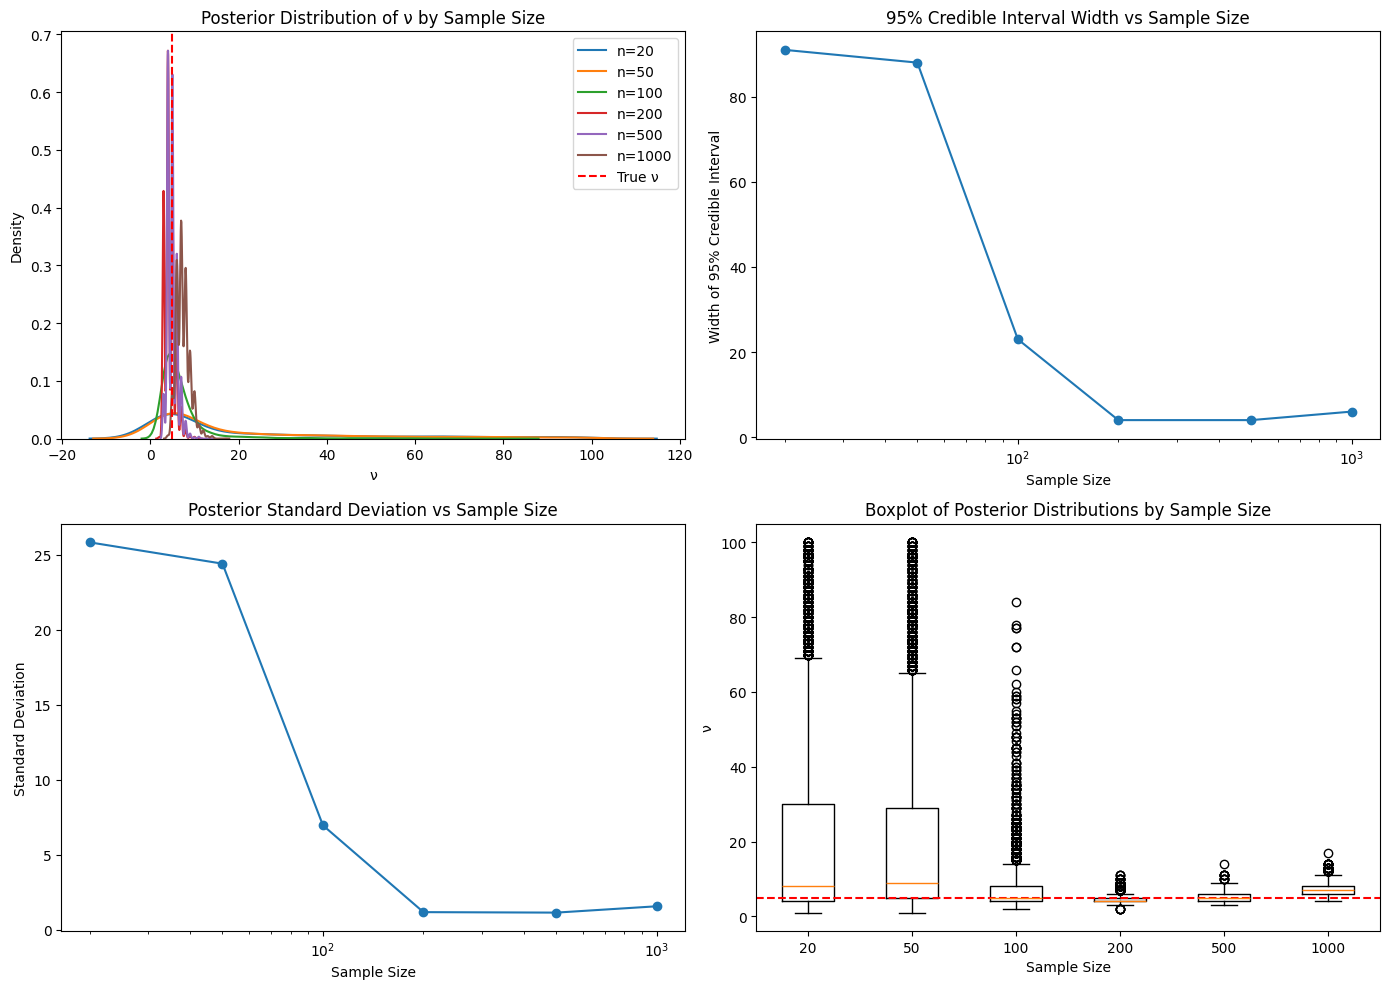

Summary of Posterior Distributions for ν:
          Mean Median Mode         SD HDI_2.5% HDI_97.5%
20      21.465    8.0    4  25.815214      1.0      92.0
50    20.93675    9.0    6  24.393724      2.0      90.0
100    7.18575    5.0    4   6.942964      3.0      26.0
200    4.36225    4.0    4    1.15889      3.0       7.0
500     4.9285    5.0    4   1.127337      3.0       7.0
1000   7.42475    7.0    7   1.549625      5.0      11.0

Absolute Error from True Value:
20        16.465
50      15.93675
100      2.18575
200      0.63775
500       0.0715
1000     2.42475
Name: Absolute Error, dtype: object

Relative Reduction in Uncertainty (compared to n=20):
n=50: 3.30% reduction in 95% credible interval width
n=100: 74.73% reduction in 95% credible interval width
n=200: 95.60% reduction in 95% credible interval width
n=500: 95.60% reduction in 95% credible interval width
n=1000: 93.41% reduction in 95% credible interval width


In [5]:
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats

np.random.seed(365)

# True parameter values
true_mu = 0.5
true_sigma2 = 2.0
true_nu = 5

# Function to generate data and run inference
def run_inference_with_sample_size(n_samples, n_draws=2000):
    """
    Generate t-distributed data with given sample size and run Bayesian inference
    
    Parameters:
    -----------
    n_samples : int
        Number of data points to generate
    n_draws : int
        Number of posterior samples to draw
        
    Returns:
    --------
    InferenceData object with posterior samples
    """
    # Generate data
    x = stats.t(df=true_nu, loc=true_mu, scale=np.sqrt(true_sigma2)).rvs(n_samples)
    
    # Create PyMC model
    with pm.Model() as model:
        # Priors
        mu = pm.Normal('mu', mu=0.0, sigma=1.0)
        sigma2 = pm.HalfNormal('sigma2', sigma=np.sqrt(5.0))
        
        # For ν, we'll use a DiscreteUniform prior from 1 to 100
        nu = pm.DiscreteUniform('nu', lower=1, upper=100)
        
        # Likelihood
        likelihood = pm.StudentT('likelihood', nu=nu, mu=mu, sigma=np.sqrt(sigma2), observed=x)
        
        # Sample from the posterior
        idata = pm.sample(n_draws, tune=1000, return_inferencedata=True,
                          target_accept=0.9, chains=2)
        
    return idata

# Sample sizes to test
sample_sizes = [20, 50, 100, 200, 500, 1000]

# Dictionary to store results
results = {}

# Run inference for each sample size
for n in sample_sizes:
    print(f"Running inference with sample size = {n}")
    results[n] = run_inference_with_sample_size(n)

# Analyze the results
nu_summary = pd.DataFrame(index=sample_sizes, 
                         columns=['Mean', 'Median', 'Mode', 'SD', 'HDI_2.5%', 'HDI_97.5%'])

for n in sample_sizes:
    posterior_nu = results[n].posterior.nu.values.flatten()
    
    # Calculate summary statistics
    nu_summary.loc[n, 'Mean'] = np.mean(posterior_nu)
    nu_summary.loc[n, 'Median'] = np.median(posterior_nu)
    
    # Fix for stats.mode() in newer scipy versions
    mode_result = stats.mode(posterior_nu)
    if hasattr(mode_result, 'mode'):
        # New scipy version returns an object with 'mode' attribute
        if isinstance(mode_result.mode, np.ndarray):
            nu_summary.loc[n, 'Mode'] = mode_result.mode[0]
        else:
            nu_summary.loc[n, 'Mode'] = mode_result.mode
    else:
        # Older scipy returns a tuple
        nu_summary.loc[n, 'Mode'] = mode_result[0][0]
    
    nu_summary.loc[n, 'SD'] = np.std(posterior_nu)
    nu_summary.loc[n, 'HDI_2.5%'] = np.percentile(posterior_nu, 2.5)
    nu_summary.loc[n, 'HDI_97.5%'] = np.percentile(posterior_nu, 97.5)
    
# Create visualization of results
plt.figure(figsize=(14, 10))

# Plot 1: Posterior distributions by sample size
plt.subplot(2, 2, 1)
for n in sample_sizes:
    sns.kdeplot(results[n].posterior.nu.values.flatten(), label=f'n={n}')
plt.axvline(true_nu, color='red', linestyle='--', label='True ν')
plt.title('Posterior Distribution of ν by Sample Size')
plt.xlabel('ν')
plt.legend()

# Plot 2: Credible interval width vs sample size
plt.subplot(2, 2, 2)
interval_width = nu_summary['HDI_97.5%'] - nu_summary['HDI_2.5%']
plt.plot(sample_sizes, interval_width, 'o-')
plt.title('95% Credible Interval Width vs Sample Size')
plt.xlabel('Sample Size')
plt.ylabel('Width of 95% Credible Interval')
plt.xscale('log')

# Plot 3: Posterior standard deviation vs sample size
plt.subplot(2, 2, 3)
plt.plot(sample_sizes, nu_summary['SD'], 'o-')
plt.title('Posterior Standard Deviation vs Sample Size')
plt.xlabel('Sample Size')
plt.ylabel('Standard Deviation')
plt.xscale('log')

# Plot 4: Box plots of posterior distributions
plt.subplot(2, 2, 4)
box_data = [results[n].posterior.nu.values.flatten() for n in sample_sizes]
plt.boxplot(box_data, labels=sample_sizes)
plt.axhline(true_nu, color='red', linestyle='--')
plt.title('Boxplot of Posterior Distributions by Sample Size')
plt.xlabel('Sample Size')
plt.ylabel('ν')

plt.tight_layout()
plt.show()

# Print summary table
print("Summary of Posterior Distributions for ν:")
print(nu_summary)

# Calculate absolute error from true value
nu_summary['Absolute Error'] = abs(nu_summary['Mean'] - true_nu)
print("\nAbsolute Error from True Value:")
print(nu_summary['Absolute Error'])

# Calculate relative reduction in uncertainty
print("\nRelative Reduction in Uncertainty (compared to n=20):")
base_width = nu_summary.loc[20, 'HDI_97.5%'] - nu_summary.loc[20, 'HDI_2.5%']
for n in sample_sizes[1:]:
    current_width = nu_summary.loc[n, 'HDI_97.5%'] - nu_summary.loc[n, 'HDI_2.5%']
    reduction = (base_width - current_width) / base_width * 100
    print(f"n={n}: {reduction:.2f}% reduction in 95% credible interval width")

**Summarize the fundings**

- Sample size matters when estimating parameters, however, there is also a dminishing returns when we increase the sample size. The biggest improvement come between n = 200 and n = 500, where the HDI width shrinks from 91 to 4.
- The posterior distribution is visibly right-skewed with the mean much larger than the median. This skewness diminishes with larger smaples
- Mode is constitently closer to the true value than the mean, even with smaller sample sizes.

### Q3: the posterior predictive distribution does something like the following...

Let $p(\tau_i)$ be $\require{cancel} \textrm{gamma}\big(\tau_i | \alpha = \frac{\nu}{2}, \overset{\textrm{rate}\xcancel{\textrm{scale}}}{\beta = \frac{\nu}{2}}\big)$ and let $p(y_i|\tau_i)$ be $\textrm{N}(y_i | 0,\tau_i)$ and now integrate out the uncertainty in $\tau_i$ and see what distribution is left over for $y_i$.

*Go look at the gamma distribution and remember that you know that the integrals of unnormalized densities are the inverse of their normalizing constants. Then go look at the t distribution and determine what distribution the following expression defines. Then explain why the behavior demonstrated here is analagous to that of the posterior predictive distribution.*

$$\int p(y_i|\tau_i) p(\tau_i)  d\tau_i = \int \sqrt{\frac{\tau_i}{2\pi}}e^{-\frac{1}{2}\tau_i y_i^2} \frac {\frac{\nu}{2}^{\frac{\nu}{2}}}{\Gamma \left(\frac{\nu}{2}\right)} \tau_i^{\frac{\nu}{2}-1}e^{-\frac{\nu}{2}\tau_i} d\tau_i$$



![title](img/hw6_q3.png)

- In the posterior predictive, we integrate over the posterior distribution of parameters: $p(\tilde{y}|y) = \int p(\tilde{y}|\theta) p (\theta|y)d\theta$
- In this example, we integrated over the prior distribution of $\tau_i : p(y_i) = \int p(y_i|\tau_i)p(\tau_i) d\tau_i$

Both cases involve averaging a conditional distirbution over a distribution of parameters, which accounts for parameter uncertainty. This leads to distributions with heavier tails than if we had fixed the parameters at specific values.

The posterior predictive distribution specifically incorporates the learning that has occured from observing data, while this example shows the result of incorporating prior uncertainty about a precision parameter. The mathematical structure and intepretation are analogous: both show how parameter uncertainty propogates to predictions about observable variables.